In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import time
from multiprocessing import Pool
from tqdm.auto import tqdm
import re

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
import matplotlib as mpl
import matplotlib.colors as mplc

mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "DejaVu Sans"
mpl.rcParams['font.size'] = 6

mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.pad'] = 0.5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.pad'] = 0.5
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 3
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['legend.handletextpad'] = 0.4
mpl.rcParams['legend.columnspacing'] = 1.0
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['figure.subplot.top'] = 0.75
mpl.rcParams['figure.subplot.bottom'] = 0.25
mpl.rcParams['figure.subplot.left'] = 0.25
mpl.rcParams['figure.subplot.right'] = 0.75

In [3]:
filename = 'data/20250411_chromatin_dynamics_all_data.h5'
data = nl.io.load.hdf5(filename, '/data')

In [4]:
colors = {
    'blue'    : '#0077BB',
    'cyan'    : '#33BBEE',
    'teal'    : '#009988',
    'orange'  : '#EE7733',
    'red'     : '#CC3311',
    'magenta' : '#EE3377',
    'grey'    : '#BBBBBB',
}

# Plots

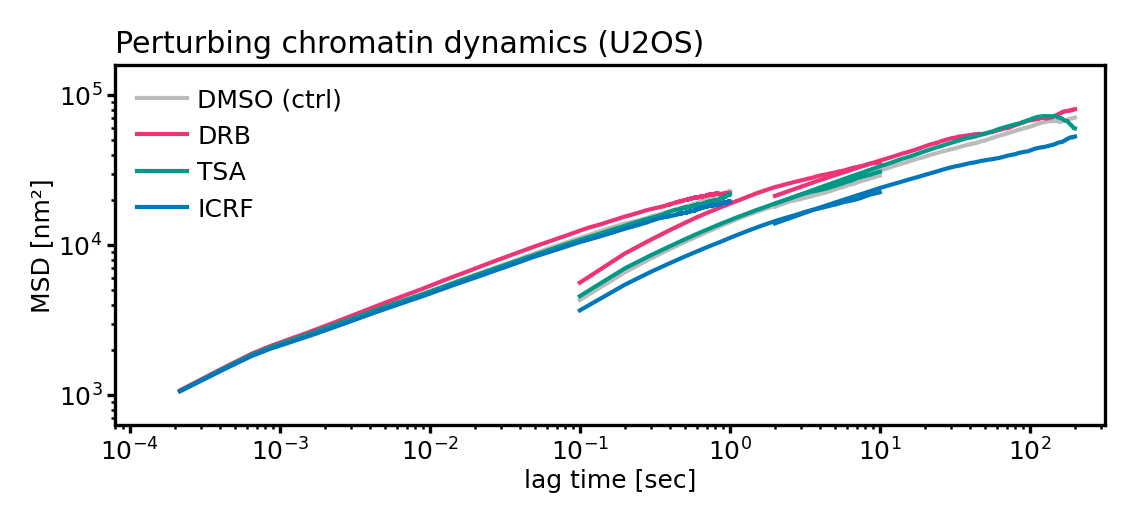

In [6]:
ct = 'U2OS' # set 'U2OS' or 'mESC'

drug_colors = {
    'DMSO' : colors['grey'],
    'DRB'  : colors['magenta'],
    'TSA'  : colors['teal'],
    'ICRF' : colors['blue'],
}

fig = plt.figure(figsize=[6.6, 2.4])

for treatment in ['ctrl', 'DRB', 'TSA', 'ICRF']:
    cond = f'H2B, {ct}, {treatment}'
    drug = 'DMSO' if treatment=='ctrl' else treatment
    
    kw_data = dict(color=drug_colors[drug], linewidth=1)
    plt.plot(0, 0, **kw_data, label=drug+' (ctrl)' if drug == 'DMSO' else drug)

    ## minflux

    data.makeSelection(cond)
    data.refineSelection('minflux')
    msd = nl.analysis.MSD(data)*1e18 # nm²

    dt = data[0].meta['Δt']
    t = dt*np.arange(1, len(msd))
    ind = t <= 1

    plt.plot(t[ind], msd[1:][ind], **kw_data)

    ## SPT

    framerates = {'100ms' : (0.1, 0.08671), '2s' : (2, 0.08671)}
    for dt_tag in framerates:
        dt, tau_e = framerates[dt_tag]

        data.makeSelection([cond, 'SPT', dt_tag], logic=all)
        msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc

        dt = data[0].meta['Δt']
        t = np.arange(1, len(msd))
        ind = t <= 100
        t = t * dt

        plt.plot(t[ind], msd[1:][ind], **kw_data)
        
## Formatting
plt.legend(loc='upper left')

plt.title(f'Perturbing chromatin dynamics ({ct})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [nm²]')
plt.ylim([10**(2.8), 10**(5.2)])
plt.xlim([10**(-4.1), 10**(2.5)])

# plt.savefig(f'{ct}_perturbations.pdf')
plt.show()

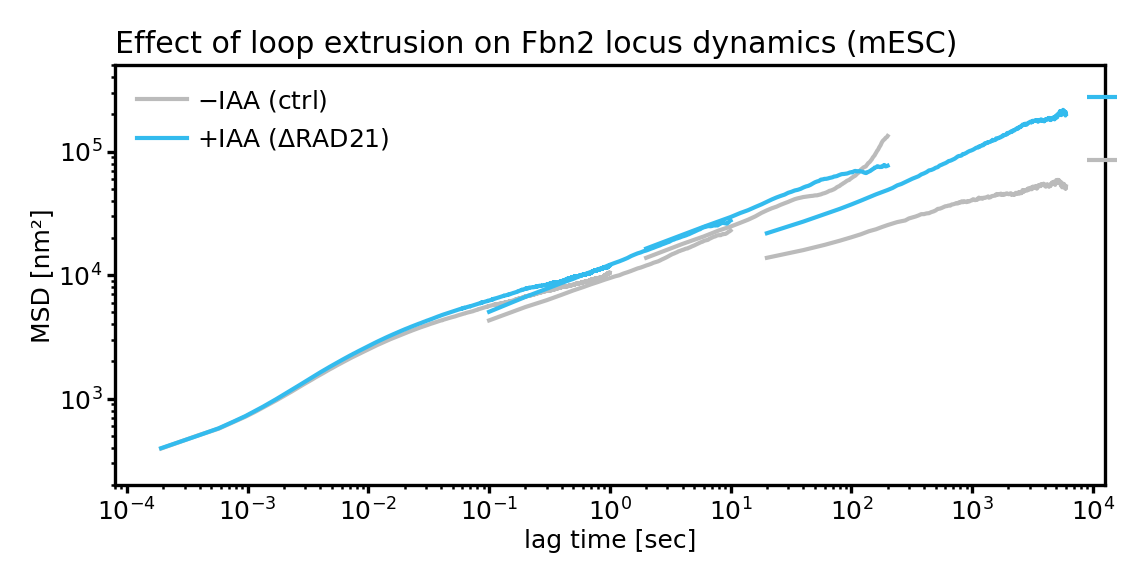

In [7]:
fig = plt.figure(figsize=[6.6, 2.8])

colors_Fbn2 = {
    'ΔRAD21 (inactive)' : colors['grey'],
    'ΔRAD21 (active)'   : colors['cyan'],
}
labels = {
    'ΔRAD21 (inactive)' : '$-$IAA (ctrl)',
    'ΔRAD21 (active)'   : '$+$IAA (ΔRAD21)',
}

for tag in ['ΔRAD21 (inactive)', 'ΔRAD21 (active)']:
    kw_data = dict(color=colors_Fbn2[tag], linewidth=1, zorder=10)
    plt.plot(0, 0, **kw_data, label=labels[tag])

    ## minflux
    
    data.makeSelection(['array', tag, 'minflux'], logic=all)
    msd = nl.analysis.MSD(data)*1e18 # nm²

    dt = data[0].meta['Δt']
    t = dt*np.arange(1, len(msd))
    ind = t <= 1

    plt.plot(t[ind], msd[1:][ind], **kw_data)

    ## SPT

    framerates = {'100ms' : (0.1, 0.08671), '2s' : (2, 0.08671)}
    for dt_tag in framerates:
        dt, tau_e = framerates[dt_tag]

        data.makeSelection(['array', tag, 'SPT', dt_tag], logic=all)
        msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc

        dt = data[0].meta['Δt']
        t = np.arange(1, len(msd))
        ind = t <= 100
        t = t * dt

        plt.plot(t[ind], msd[1:][ind], **kw_data)

    ## SRLCI

    data.makeSelection(['array', tag, 'SRLCI'], logic=all)
    msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc
    J = np.nanmean(np.concatenate([traj.abs()[:][:, 0] for traj in data])**2)/2*1e6

    dt = data[0].meta['Δt']
    t = np.arange(1, len(msd))
    ind = t <= 300
    t = t * dt

    plt.plot(t[ind], msd[1:][ind], **kw_data)
    plt.hlines(2*J, 9e3, 10**(4.2), **kw_data, clip_on=False)
        
## Formatting

plt.legend(loc='upper left')

plt.title('Effect of loop extrusion on Fbn2 locus dynamics (mESC)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [nm²]')
plt.xticks(np.logspace(-4, 5, 10))
plt.gca().set_xticks([i*10**j for j in range(-5, 6) for i in range(2, 10)], minor=True)
plt.ylim([10**(2.3), 10**(5.7)])
plt.xlim([10**(-4.1), 10**(4.1)])

# plt.savefig(f'array_perturbations.pdf')
plt.show()

# Inset plots
Visualize the overall effects of drugs

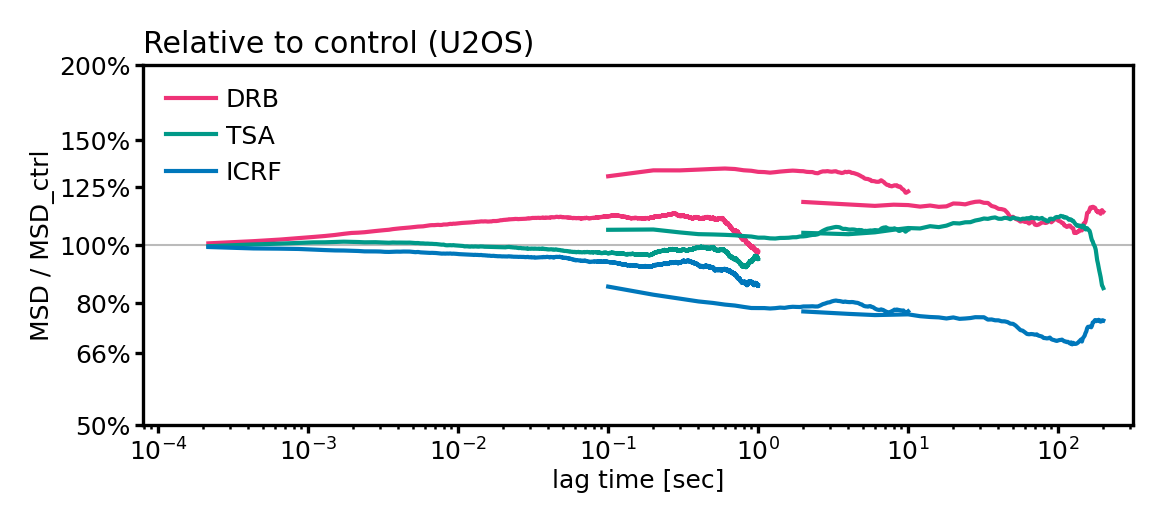

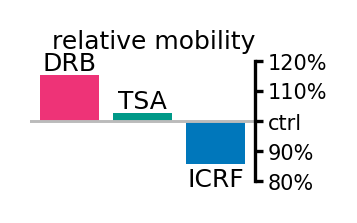

In [9]:
ct = 'U2OS' # set 'U2OS' or 'mESC'

drug_colors = {
    'DMSO' : colors['grey'],
    'DRB'  : colors['magenta'],
    'TSA'  : colors['teal'],
    'ICRF' : colors['blue'],
}

fig = plt.figure(figsize=[6.6, 2.4])

### reference (ctrl)
## minflux
ref_msds = {}
cond = f'H2B, {ct}, ctrl'

data.makeSelection(cond)
data.refineSelection('minflux')

msd = nl.analysis.MSD(data)*1e18 # nm²
dt = data[0].meta['Δt']
Tmax = int(1/dt)+1

ref_msds['minflux'] = [dt, Tmax, msd]

## SPT
framerates = {'100ms' : (0.1, 0.08671), '2s' : (2, 0.08671)}
for dt_tag in framerates:
    dt, tau_e = framerates[dt_tag]
    data.makeSelection([cond, 'SPT', dt_tag], logic=all)
    
    msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc
    dt = data[0].meta['Δt']
    Tmax = 101
    
    ref_msds['SPT-'+dt_tag] = [dt, Tmax, msd]

### Treatments
relative_msds = {}
for treatment in ['DRB', 'TSA', 'ICRF']:
    cond = f'H2B, {ct}, {treatment}'
    drug = treatment
    
    relative_msds[treatment] = {}
    
    kw_data = dict(color=drug_colors[drug], linewidth=1)
    plt.plot(0, 0, **kw_data, label=drug)

    ## minflux

    data.makeSelection(cond)
    data.refineSelection('minflux')
    msd = nl.analysis.MSD(data)*1e18 # nm²

    dt, Tmax, refmsd = ref_msds['minflux']
    t = dt*np.arange(1, Tmax)
    rel = msd[1:Tmax]/refmsd[1:Tmax]
    plt.plot(t, rel, **kw_data)
    relative_msds[treatment]['minflux'] = [t, rel]

    ## SPT

    framerates = {'100ms' : (0.1, 0.08671), '2s' : (2, 0.08671)}
    for dt_tag in framerates:
        dt, tau_e = framerates[dt_tag]

        data.makeSelection([cond, 'SPT', dt_tag], logic=all)
        msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc

        dt, Tmax, refmsd = ref_msds['SPT-'+dt_tag]
        t = dt*np.arange(1, Tmax)
        rel = msd[1:Tmax]/refmsd[1:Tmax]
        plt.plot(t, rel, **kw_data)
        relative_msds[treatment]['SPT-'+dt_tag] = [t, rel]
        
## Formatting
plt.legend(loc='upper left')
plt.axhline(1, color=colors['grey'], zorder=0, linewidth=0.5)

plt.title(f'Relative to control ({ct})')
plt.xscale('log')
plt.yscale('log', base=2)
plt.xlabel('lag time [sec]')
plt.ylabel('MSD / MSD_ctrl')
yticks = [0.5, 0.66, 0.8, 1, 1.25, 1.5, 2]
plt.yticks(yticks, labels=[f'{tick:.0%}' for tick in yticks])
plt.ylim([0.5, 2])
plt.xlim([10**(-4.1), 10**(2.5)])

plt.show()

# Integrate relative MSDs
treatments = ['DRB', 'TSA', 'ICRF']
integrals = np.zeros(len(treatments))
for i, treatment in enumerate(treatments):
    keys = list(relative_msds[treatment].keys())
    Dlogdt_total = 0
    int_total = 0
    for key in keys:
        t, rel = relative_msds[treatment][key]
        int_total += integrate.trapezoid(y=np.log(rel), x=np.log(t))
        Dlogdt_total += np.log(t[-1])-np.log(t[0])
    
    integrals[i] = int_total / Dlogdt_total

fig = plt.figure(figsize=[1.5, 0.8])

for i, (treatment, val) in enumerate(zip(treatments, integrals)):
    color=drug_colors[treatment]
    plt.bar(i, np.exp(val)-1, bottom=1, color=color)
    
    y = np.exp(val)
    if val < 0:
        y *= 0.99
    plt.text(i, y, treatment,
             ha='center', va='top' if val < 0 else 'bottom',
            )
    
plt.axhline(1, color=colors['grey'], zorder=1, linewidth=0.7)

yticks = [0.8, 0.9, 1, 1.1, 1.2]
plt.yticks(yticks, labels=['ctrl' if tick == 1 else f'{tick:.0%}' for tick in yticks], fontsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.tick_right()
plt.title('relative mobility', fontsize=6, loc='right')

# plt.savefig(f'{ct}_relative_mobility.pdf')
plt.show()

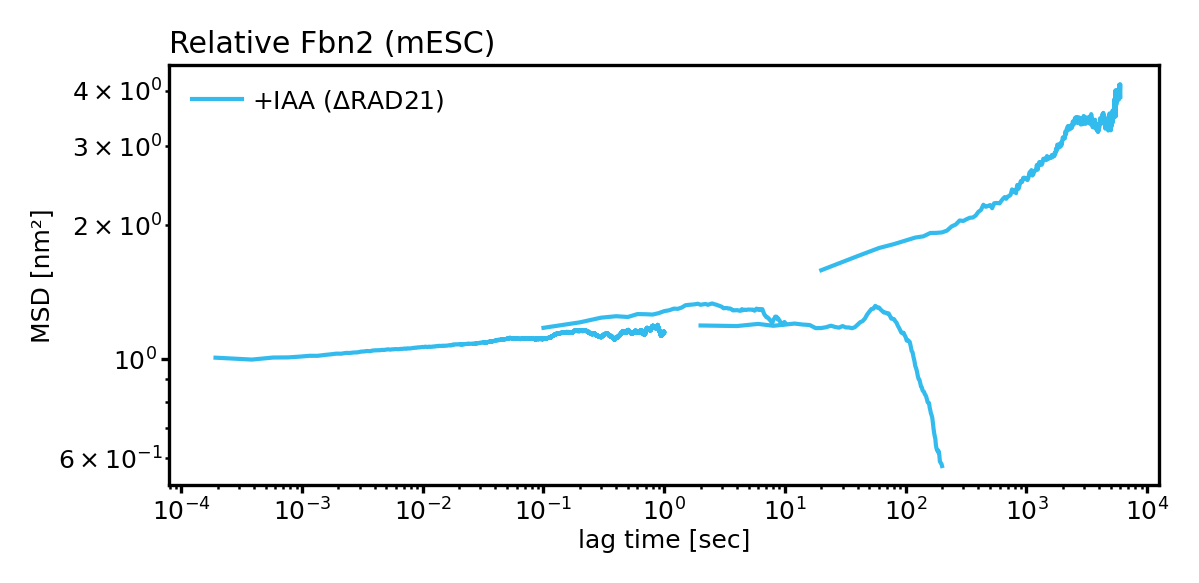

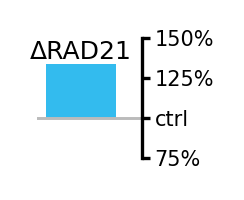

In [11]:
fig = plt.figure(figsize=[6.6, 2.8])

colors_Fbn2 = {
    'ΔRAD21 (inactive)' : colors['grey'],
    'ΔRAD21 (active)'   : colors['cyan'],
}
labels = {
    'ΔRAD21 (inactive)' : '$-$IAA (ctrl)',
    'ΔRAD21 (active)'   : '$+$IAA (ΔRAD21)',
}

### Reference (ctrl)
ref_msds = {}
tag = 'ΔRAD21 (inactive)'

## minflux
data.makeSelection(['array', tag, 'minflux'], logic=all)

msd = nl.analysis.MSD(data)*1e18 # nm²
dt = data[0].meta['Δt']
Tmax = int(1/dt)+1

ref_msds['minflux'] = [dt, Tmax, msd]

## SPT
framerates = {'100ms' : (0.1, 0.08671), '2s' : (2, 0.08671)}
for dt_tag in framerates:
    dt, tau_e = framerates[dt_tag]

    data.makeSelection(['array', tag, 'SPT', dt_tag], logic=all)
    msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc
    dt = data[0].meta['Δt']
    Tmax = 101

    ref_msds['SPT-'+dt_tag] = [dt, Tmax, msd]

## SRLCI
data.makeSelection(['array', tag, 'SRLCI'], logic=all)
data_msd = data.apply(lambda traj: traj.dims([0, 1], keepmeta=['Δt']))
msd = nl.analysis.MSD(data_msd)/2*1e6 # nm², 2-loc --> 1-loc
J = np.nanmean(np.concatenate([traj.abs()[:][:, 0] for traj in data_msd])**2)/2*1e6
dt = data[0].meta['Δt']
Tmax = 301

ref_msds['SRLCI'] = [dt, Tmax, msd]

relative_msds = {}
for tag in ['ΔRAD21 (active)']:
    kw_data = dict(color=colors_Fbn2[tag], linewidth=1, zorder=10)
    plt.plot(0, 0, **kw_data, label=labels[tag])
    relative_msds[tag] = {}

    ## minflux
    data.makeSelection(['array', tag, 'minflux'], logic=all)
    msd = nl.analysis.MSD(data)*1e18 # nm²

    dt, Tmax, refmsd = ref_msds['minflux']
    t = dt*np.arange(1, Tmax)
    rel = msd[1:Tmax]/refmsd[1:Tmax]
    plt.plot(t, rel, **kw_data)
    relative_msds[tag]['minflux'] = [t, rel]

    ## SPT
    framerates = {'100ms' : (0.1, 0.08671), '2s' : (2, 0.08671)}
    for dt_tag in framerates:
        dt, tau_e = framerates[dt_tag]

        data.makeSelection(['array', tag, 'SPT', dt_tag], logic=all)
        msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc

        dt, Tmax, refmsd = ref_msds['SPT-'+dt_tag]
        t = dt*np.arange(1, Tmax)
        rel = msd[1:Tmax]/refmsd[1:Tmax]
        plt.plot(t, rel, **kw_data)
        relative_msds[tag]['SPT-'+dt_tag] = [t, rel]
    
    ## SRLCI
    data.makeSelection(['array', tag, 'SRLCI'], logic=all)
    data_msd = data.apply(lambda traj: traj.dims([0, 1], keepmeta=['Δt']))
    msd = nl.analysis.MSD(data_msd)/2*1e6 # nm², 2-loc --> 1-loc
    J = np.nanmean(np.concatenate([traj.abs()[:][:, 0] for traj in data_msd])**2)/2*1e6

    dt, Tmax, refmsd = ref_msds['SRLCI']
    t = dt*np.arange(1, Tmax)
    rel = msd[1:Tmax]/refmsd[1:Tmax]
    plt.plot(t, rel, **kw_data)
    relative_msds[tag]['SRLCI'] = [t, rel]
        
## Formatting

plt.legend(loc='upper left')

plt.title('Relative Fbn2 (mESC)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [nm²]')
plt.xticks(np.logspace(-4, 5, 10))
plt.gca().set_xticks([i*10**j for j in range(-5, 6) for i in range(2, 10)], minor=True)
# plt.ylim([10**(2.3), 10**(5.7)])
plt.xlim([10**(-4.1), 10**(4.1)])

plt.show()

# Integrate relative MSDs
tags = list(relative_msds.keys())
integrals = np.zeros(len(tags))
for i, tag in enumerate(tags):
    keys = list(relative_msds[tag].keys())
    Dlogdt_total = 0
    int_total = 0
    for key in keys:
        t, rel = relative_msds[tag][key]
        int_total += integrate.trapezoid(y=np.log(rel), x=np.log(t))
        Dlogdt_total += np.log(t[-1])-np.log(t[0])
    
    integrals[i] = int_total / Dlogdt_total

fig = plt.figure(figsize=[0.7, 0.8])

for i, (tag, val) in enumerate(zip(tags, integrals)):
    color=colors_Fbn2[tag]
    plt.bar(i, np.exp(val)-1, bottom=1, color=color)
    
    y = np.exp(val)
    if val < 0:
        y *= 0.99
    plt.text(i, y, 'ΔRAD21',
             ha='center', va='top' if val < 0 else 'bottom',
            )
    
plt.axhline(1, color=colors['grey'], zorder=1, linewidth=0.7)

yticks = [0.75, 1, 1.25, 1.5]
plt.yticks(yticks, labels=['ctrl' if tick == 1 else f'{tick:.0%}' for tick in yticks], fontsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.tick_right()
# plt.title('relative mobility', fontsize=6, loc='right')
plt.xlim([-0.5, 0.7])

plt.subplots_adjust(left=0.1, right=0.6)
# plt.savefig('Fbn2_relative_mobility.pdf')
plt.show()